# Intergroup Difference Explanations

**Example.** In this example, we create a model to predict whether a criminal will recidivate within two years of release. We find that our model predicts higher recidivism rates for Black criminals than for White criminals, then use G-SHAP to identify which features are most responsible for this difference. We find that prior convictions, age, and race are the most important variables.

**General formulation.** More generally, suppose we have two groups of observations, $X_0\subseteq X$ and $X_1\subseteq X$, and a measure $d$ of how different our model output is between groups. We can ask why our model makes different predictions for different groups. Here, groups $X_0$ and $X_1$ are White and Black criminals respectively, the model output is a classification which indicates that a criminal will recidivate within two years, and the difference measure is the relative difference in recidivism rates.

In [1]:
import gshap
from gshap.datasets import load_recidivism
from gshap.intergroup import IntergroupDifference

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import random
import os

np.random.seed(0)
random.seed(0)

# directory for saving plots
# set to `None` to avoid saving plots
PLOTS_DIR = 'plots'

**Model.** We train Scikit-learn's support vector classifier with default settings on the Correctional Offender Management Profiling for Alternative Sanctions dataset, selecting only Black and White criminals ($n_\text{Black}=3565,n_\text{White}=1904$), using a 75\%-25\% train-test split. The purpose of this dataset is to predict whether a criminal will recidivate within two years of release based on demographic information and criminal history. Our classifier achieves 68\% test accuracy. The predicted recidivism rate is 63\% higher for Black criminals (65\%) than for White criminals (40\%).

Test score: 0.6780
Predicted two-year recidivism rate for Whites:  0.40
Predicted two-year recidivism rate for Blacks:  0.65
Relative difference:  0.63


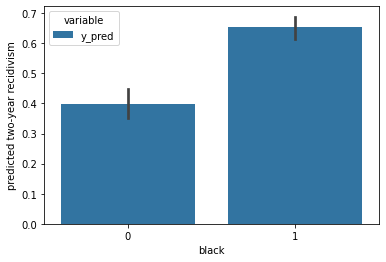

In [2]:
# model training and evaluation
recid = load_recidivism()
X, y = recid.data, recid.target
X_train, X_test, y_train, y_test = train_test_split(recid.data, recid.target, test_size=1000)
clf = SVC()
clf.fit(X_train, y_train)
print('Test score: %.4f' % clf.score(X_test, y_test))

# racial difference
df = pd.concat((X_test, y_test), axis=1)
df['y_pred'] = clf.predict(X_test)
p_non_black, p_black = df.groupby('black')['y_pred'].mean()
print('Predicted two-year recidivism rate for Whites: % .2f' % p_non_black)
print('Predicted two-year recidivism rate for Blacks: % .2f' % p_black)
print('Relative difference: % .2f' % (p_black/p_non_black - 1))

df['id'] = df.index
df = df.melt(('id', 'black'), value_vars='y_pred')
sns.barplot(y='value', x='black', hue='variable', data=df)
plt.ylabel('predicted two-year recidivism')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'recidivism_differnce.png'))
plt.show()

We plot the correlations of all variables in our dataset with race (Black) and two-year recidivism. Visually, it is unclear which variables lead our model to believe that Black criminals are at higher risk for recidivism.

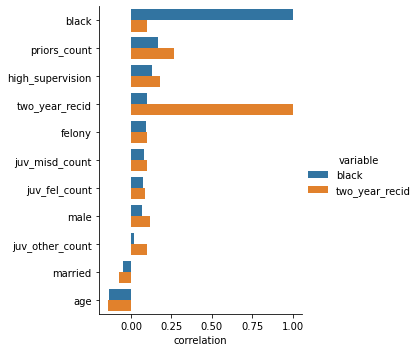

In [3]:
corr_df = recid.df.corr().sort_values('black', ascending=False).reset_index()
corr_df = corr_df.melt('index', value_vars=('black', 'two_year_recid'))
sns.catplot(
    x='value',
    y='index',
    hue='variable',
    data=corr_df,
    kind='bar',
    orient='h'
)
plt.xlabel('correlation')
plt.ylabel('')
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'recidivism_corr.png'), bbox_inches='tight')
plt.show()

**G-SHAP values.** We compute the G-SHAP values, where $g$ measures the difference in model outputs between groups. In this case, $d$ is the relative difference between group means. Intuitively, this measures the relative difference in predicted recidivism rates between Black and White criminals. In the binary case, relative mean difference is known as *disparate impacts* in the algorithm fairness literature.

\begin{equation}
g(f,X,\Omega) 
= d(E_{x\in X_0}[f(x)],E_{x\in X_1}[f(x)])
= \frac{n_\text{Black}^{-1}\sum_{x_i\in X_\text{Black}}\mathbf{1}(f(x_i)=\text{Recidivate})}
{n_\text{White}^{-1}\sum_{x_i\in X_\text{White}}\mathbf{1}(f(x_i)=\text{Recidivate})}
-1
\end{equation}

Where additional arguments to $g$ indicate group membership; $\Omega=\{X_0,X_1\}$.

Although we express the intergroup difference measure as a function of group means, our method easily extends to intergroup difference measures more generally; for example, a difference between group medians or a Wasserstein distance between sample distributions.

In [4]:
g = IntergroupDifference(group=X_test['black'], distance='relative_mean_distance')
explainer = gshap.KernelExplainer(clf.predict, X_train, g)
gshap_values = explainer.gshap_values(X_test, nsamples=32)

**Interpretation.** For interpretation, we compare our test data $X$ to a background dataset $Z$ (the shuffled training data) in terms of $g$. Consistent with our previous result, the relative difference in predicted recidivism rates is 63\%. The relative difference for our shuffled background data is 0\% (because the background data are shuffled, the model has no way to statistically discriminate between groups). Each G-SHAP value $\phi_g^j$ is the number of percentage points of this difference (63 percentage points) explained by feature $j$.

For intergroup difference explanations more broadly, our model predicts the distance between groups is $d(E_{x\in X_0}[f(x)],E_{x\in X_1}[f(x)])$ for our sample, and 0 for the shuffled background data. Each G-SHAP value $\phi_g^j$ is the amount of this difference explained by feature $j$.

In [5]:
g_comparison, g_background = explainer.compare(X_test, bootstrap_samples=1000)
print('Relative mean difference for test data: %.4f' % g_comparison)
print('Relative mean difference for (shuffled) background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Relative mean difference for test data: 0.6339
Relative mean difference for (shuffled) background data: 0.0007
Sum of G-SHAP values: 0.6541


**Results.** This plot tells us which features explain the relative difference in predicted recidivism rates between Black and White criminals. We see that the most important features are number of prior convictions, age, and race.

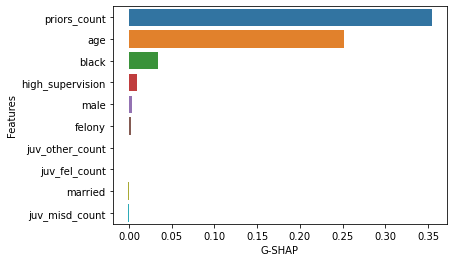

In [6]:
df = pd.DataFrame({'Features': X.columns, 'G-SHAP': gshap_values})
df = df.sort_values('G-SHAP', ascending=False)
sns.barplot(y='Features', x='G-SHAP', data=df)
if PLOTS_DIR is not None:
    plt.savefig(os.path.join(PLOTS_DIR, 'recidivism_gshap.png'), bbox_inches='tight')
plt.show()